In [1]:
%%capture
import pickle
import numpy as np
import math
import scipy as sp
from EM import EM
from plot import plot
from preprocess import preprocess
#from EM_individual_params import EM 

### Hyperparameters

In [2]:
bin_size = 60 * 18
cutoff = 5

In [3]:
data = pickle.load(open('../Data/unimputed_inr_patient_data.pkl', 'rb'), encoding='latin1')

### Preprocessing
* Choose only the data point that has at least a certain number of observations
* Make each time series (both obs and treatments) start at the time of the first observation
* Bin time series
    * Number of bins is determined by: ceil(bin size / largest last observation time)
    * If there are multiple observations in a bin, average the values
    * If there are multiple treatments of the same kind in a bin, store the number of treatments given
* Convert observations, treatment, static conditions (chronic and age) into matrix form

### Modeling choices
* Cutoff (only consider the data point with at least certain number of observations): 5 --> 2214 data points, 215 bins
* Bin size (length of time interval used to bin the time series): 18 hrs
* Parameters initialization
    * Both treatment and static coefficients: Gaussian with mean 0.1 plus small white noise
* Missingness
    * After binning the data, only consider the data points with less than 30% missing observations
* Chronic conditions and age
    * Set to zero

In [4]:
y, X, c = preprocess(data, cutoff, bin_size, missing_pct=40)

In [5]:
c = np.zeros(c.shape)

In [6]:
y.shape

(2214, 215)

In [7]:
print('percentage of patients in the data with liver disease: {}'.format\
      (np.nonzero(c[:, 0])[0].shape[0] / c.shape[0] * 100))
print('percentage of patients in the data with sickle cell: {}'.format\
      (np.nonzero(c[:, 1])[0].shape[0] / c.shape[0] * 100))

percentage of patients in the data with liver disease: 0.0
percentage of patients in the data with sickle cell: 0.0


Here for each INR observation (say at time t, t is a time point after binning), look at whether there is any treatment given at time t-1 or t-2. If so, calculate the difference between the INR value at time t and the previous observed INR value. If the difference is negative, then we say a treatment has nonincreasing effect. We do this for each of the 4 treatments

In [8]:
treatment_types = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
for j in range(5):
    treatment_effect = []
    for n in range(y.shape[0]):
        treatment = np.nonzero(X[n, :, j])[0]
        if treatment.shape[0] > 0:        
            inr_index = np.where(np.invert(np.isnan(y[n, :])))[0]
            prev_inr = np.nan
            for i in inr_index:
                prev_one = i-1
                prev_two = i-2
                prev_three = i-3
                curr_inr = y[n, i]
                if prev_one in treatment or prev_two in treatment or prev_three in treatment:
                    treatment_effect.append(curr_inr - prev_inr)
                prev_inr = curr_inr
    treatment_effect = np.array(treatment_effect)
    pct_has_effect = np.where(treatment_effect > 0)[0].shape[0] / treatment_effect.shape[0] * 100
    print('Percentage of the {} with increasing effect on INR: {}'.format(treatment_types[j], pct_has_effect))

Percentage of the nsaid with increasing effect on INR: 48.9010989010989
Percentage of the transfusion_plasma with increasing effect on INR: 26.168224299065418
Percentage of the transfusion_platelet with increasing effect on INR: 23.809523809523807
Percentage of the anticoagulant with increasing effect on INR: 54.27343223196224
Percentage of the aspirin with increasing effect on INR: 48.31305309734513


In [9]:
def find_common_elements(a, b):
    count = 0
    if a.shape[0] == 0 or b.shape[0] == 0:
        return count
    for ele in a:
        if ele in b:
            count += 1
    return count

Since anticoagulant stands out as not having obvious nonincreasing effect on INR, we try to see if its effect may interact with the effects of other treatments

In [10]:
atc_total = 0
with_ns = 0
with_plasma_tf = 0
with_platelet_tf = 0
with_asp = 0
for n in range(y.shape[0]):
    atc = np.nonzero(X[n, :, 3])[0]
    atc_total += atc.shape[0]
    if atc.shape[0] > 0:
        ns = np.nonzero(X[n, :, 0])[0]
        plasma_tf = np.nonzero(X[n, :, 1])[0]
        platelet_tf = np.nonzero(X[n, :, 2])[0]
        asp = np.nonzero(X[n, :, 4])[0]
        with_ns += find_common_elements(atc, ns)
        with_plasma_tf += find_common_elements(atc, plasma_tf)
        with_platelet_tf += find_common_elements(atc, platelet_tf)
        with_asp += find_common_elements(atc, asp)
print('anticoagulant is administered {}% times with nsaid'.format(with_ns / atc_total * 100))
print('anticoagulant is administered {}% times with plasma transfusion'.format(with_plasma_tf / atc_total * 100))
print('anticoagulant is administered {}% times with platelet transfusion'.format(with_platelet_tf / atc_total * 100))
print('anticoagulant is administered {}% times with aspirin'.format(with_asp / atc_total * 100))

anticoagulant is administered 14.787570466107521% times with nsaid
anticoagulant is administered 0.18561803932352536% times with plasma transfusion
anticoagulant is administered 0.0% times with platelet transfusion
anticoagulant is administered 17.60621476694624% times with aspirin


### Reasons for Errors
* Assume the a single set of parameters generate all the data. This assumption could be violated since:
    1. Each patient respond to treatment differently
    2. Different treatment and chronic conditions may have various interaction effects on different individuals
* After changing treatment coefficients to be on individual level, the average coefficients are similar to the case of population level coefficients. The fit on some plots improve slightly but not much.  
* Assume observed value is well explained by the treatment and chronic variable. whereas in reality there might be other variable that contributes to the observed
* Assume linear transition, emission and treatment/chronic effects
* Seeing from the data, treatments don't seem to show clear effects on INR, from plots and from calculations.

In [11]:
em = EM(y, X, c, 3, 0, .8, single_effect=False)

In [12]:
%%time
em.run_EM(2000)

1704 iterations before convergence
CPU times: user 27min, sys: 57.5 s, total: 27min 57s
Wall time: 11min 8s


In [13]:
em.get_MSE()

0.6086794121244914

In [14]:
treatment_types = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
for i, treatment in enumerate(treatment_types):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = ['chronic kidney failure', 'sickle cell', 'age']
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))

Coefficient for nsaid: [0.2815694  0.09978669 0.02479867]
Coefficient for transfusion_plasma: [0.14672529 0.08461077 0.04674391]
Coefficient for transfusion_platelet: [-0.26739883 -0.43353922 -0.31409842]
Coefficient for anticoagulant: [-0.10861229  0.13243663  0.04991824]
Coefficient for aspirin: [0.21565347 0.09210763 0.03178632]
Coefficient for chronic kidney failure: 0.0
Coefficient for sickle cell: 0.0
Coefficient for age: 0.0


Patient 460


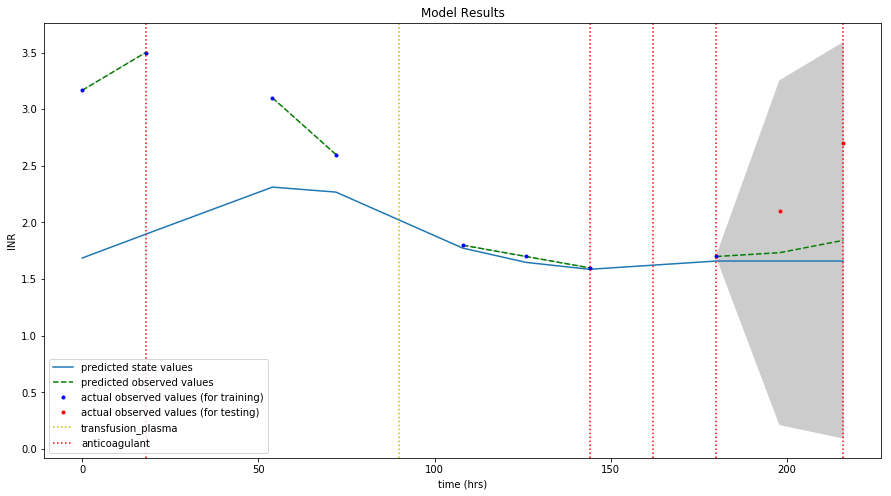

Patient 1472


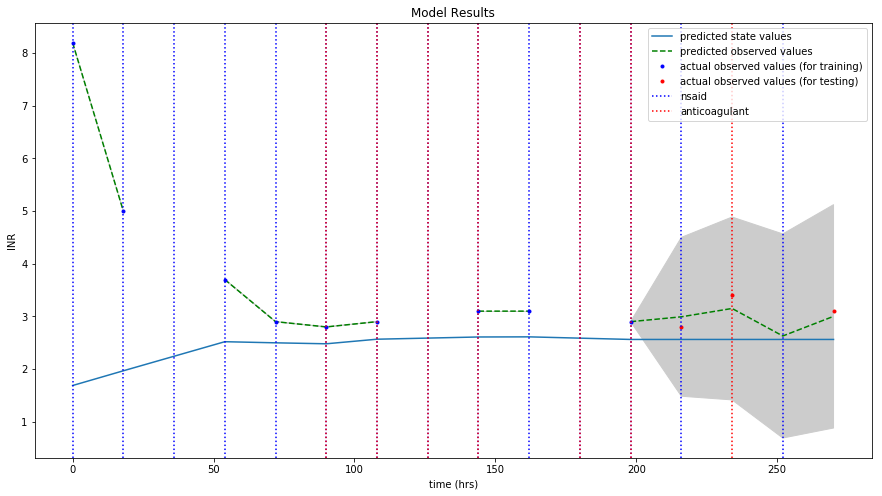

Patient 643


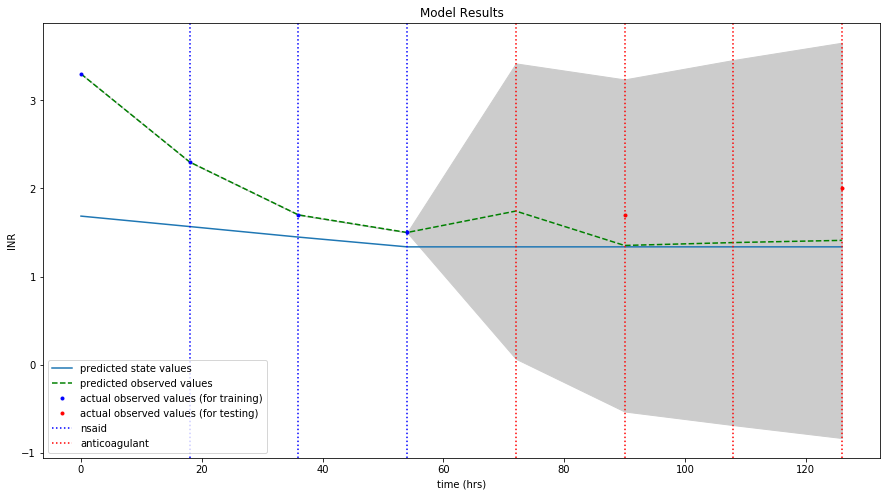

Patient 1058


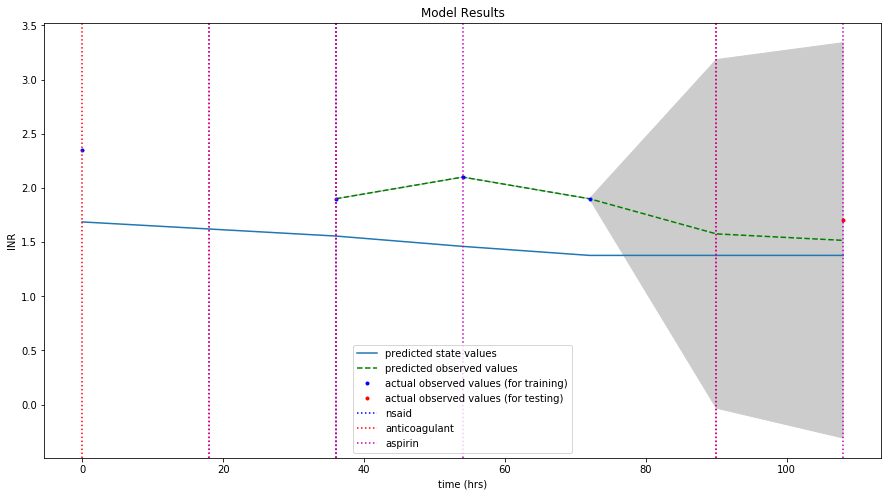

Patient 1611


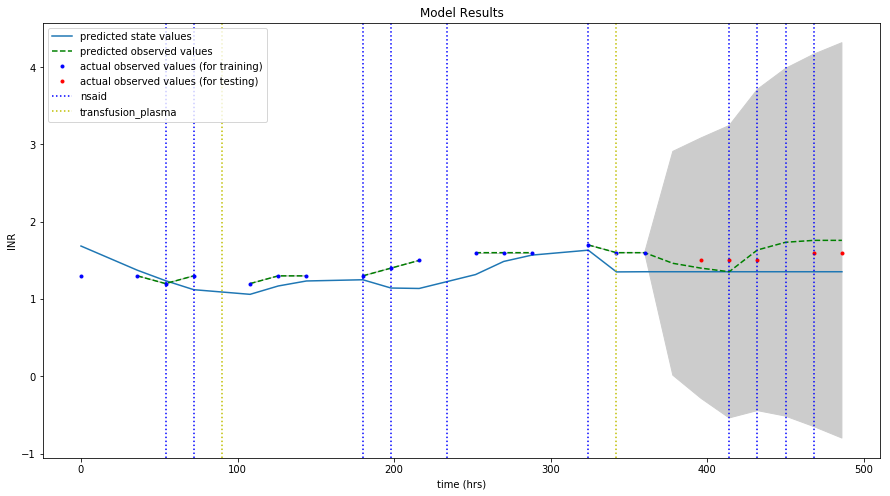

Patient 1146


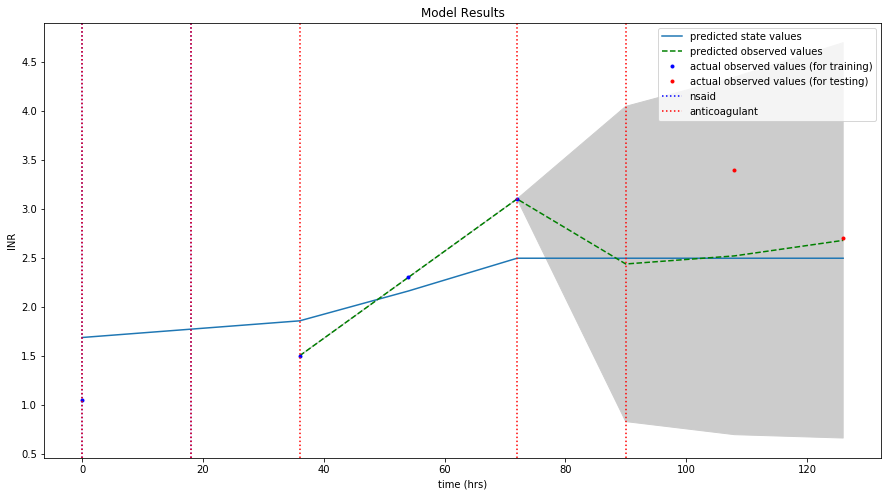

Patient 1088


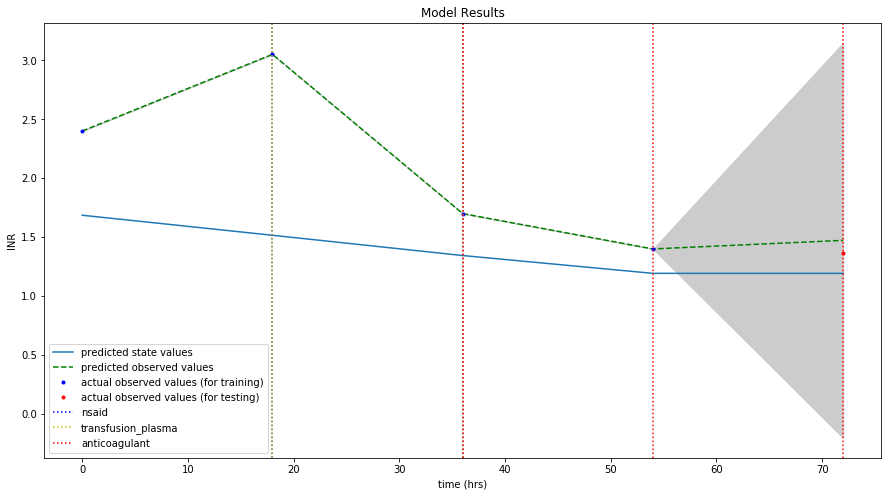

Patient 1962


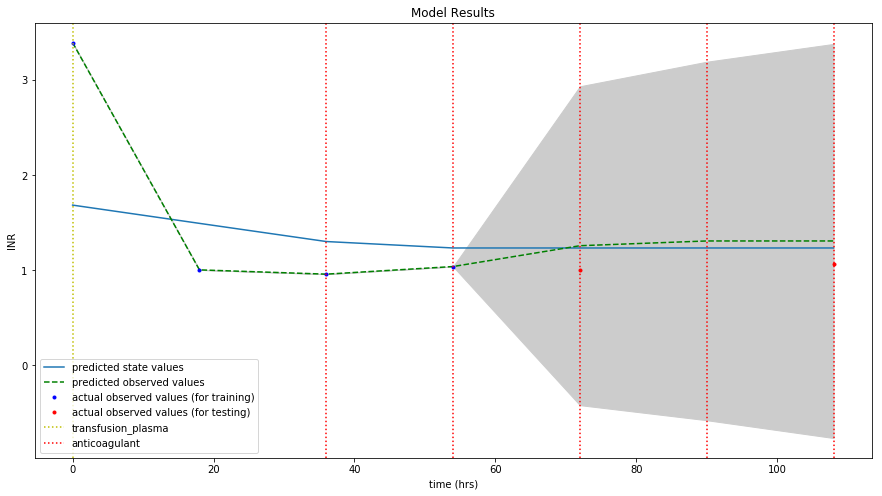

Patient 521


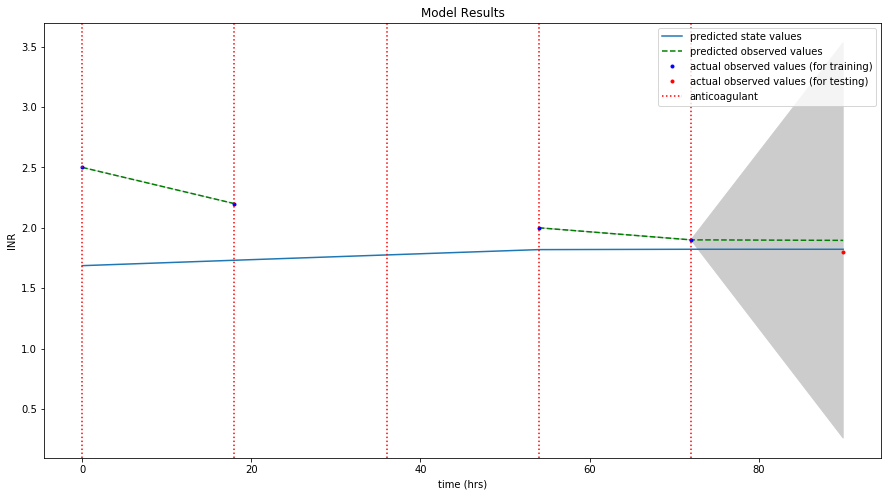

Patient 1603


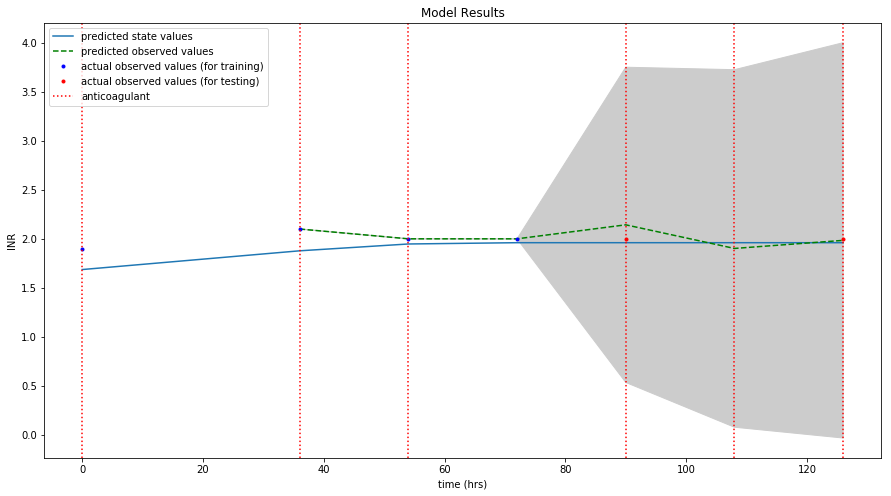

Patient 1933


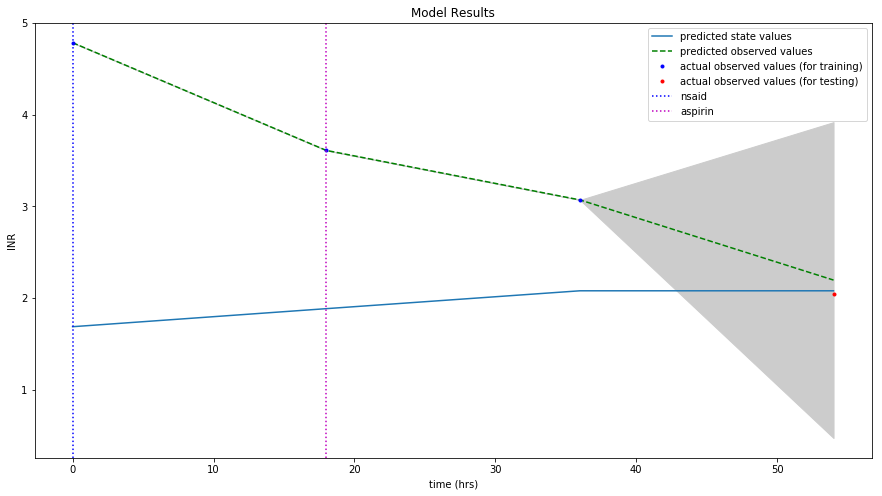

Patient 904


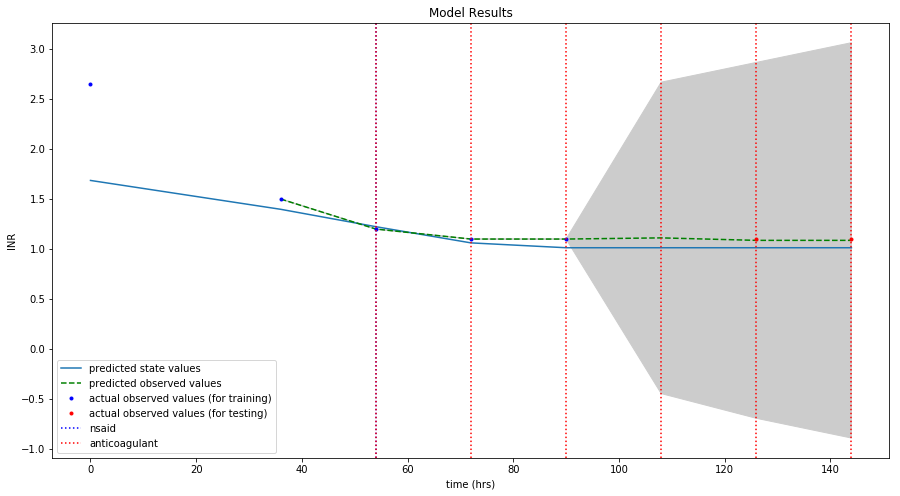

Patient 1599


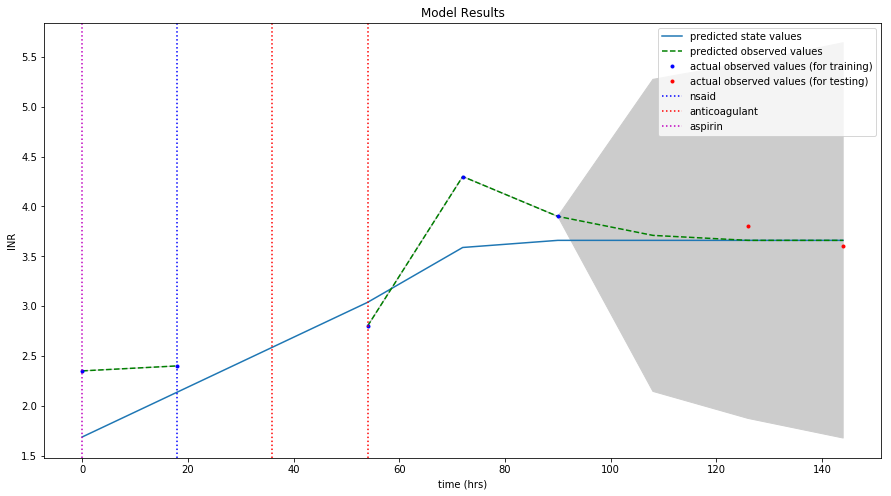

Patient 2051


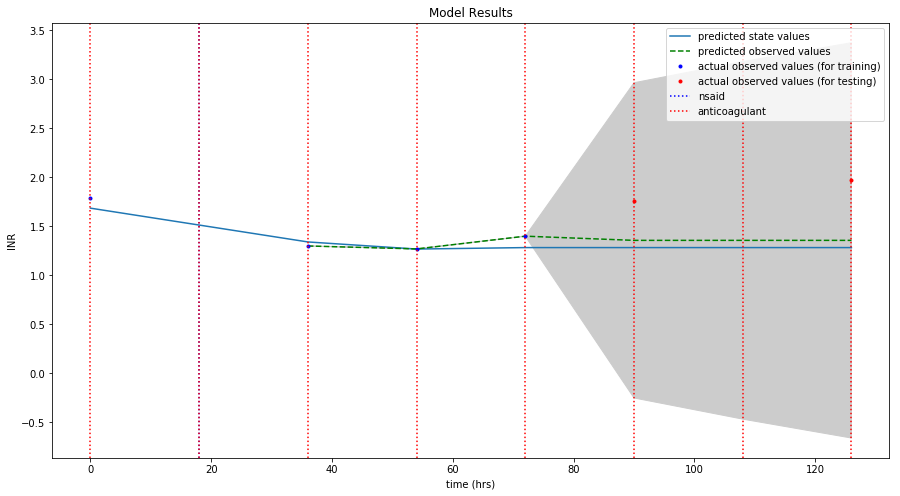

Patient 1558


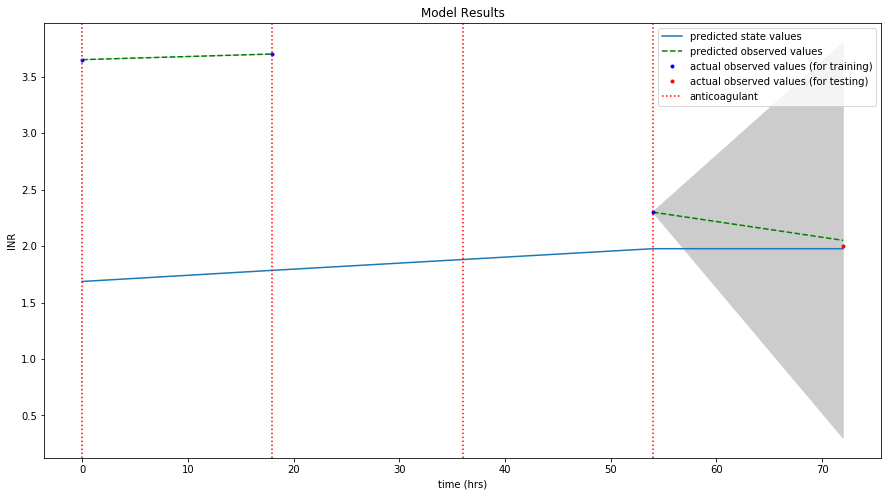

Patient 1703


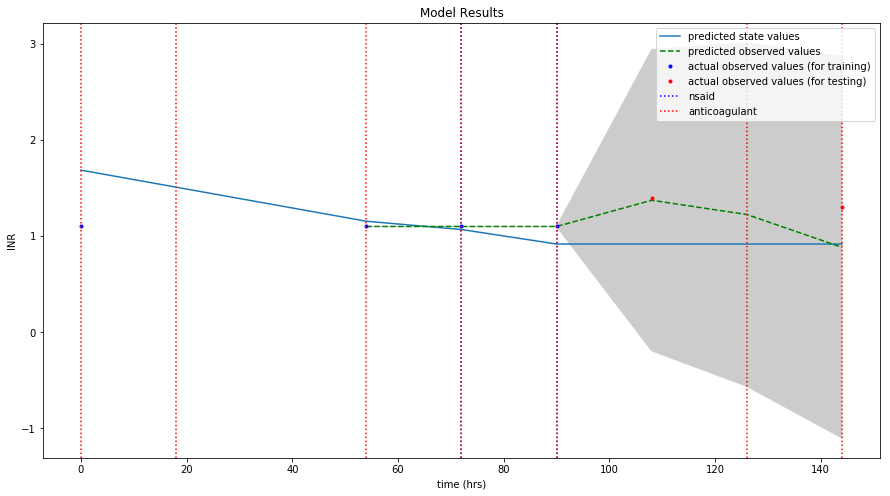

Patient 1427


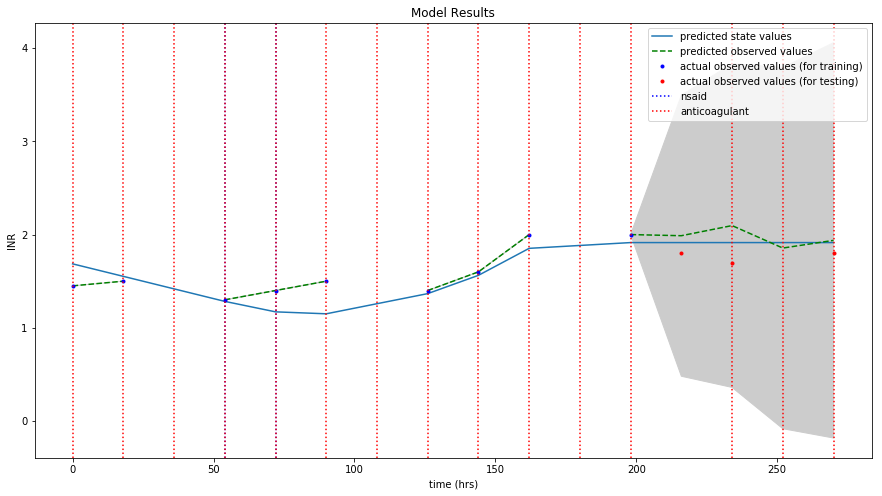

Patient 820


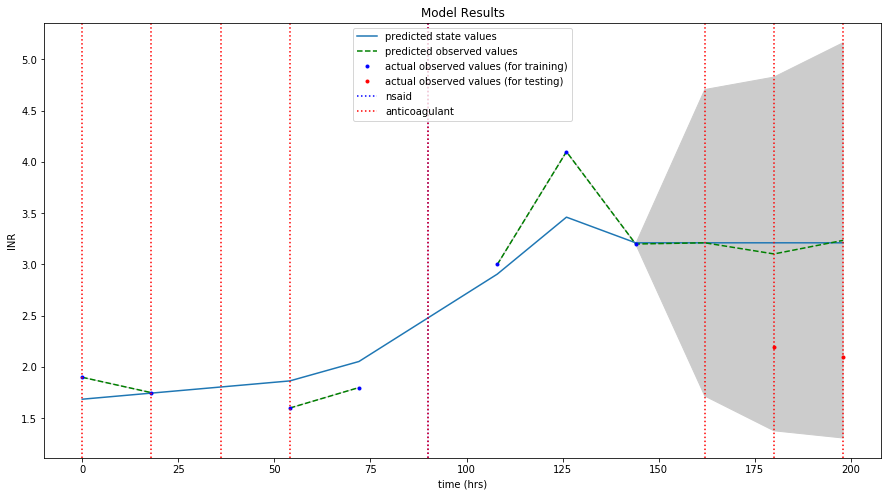

Patient 1948


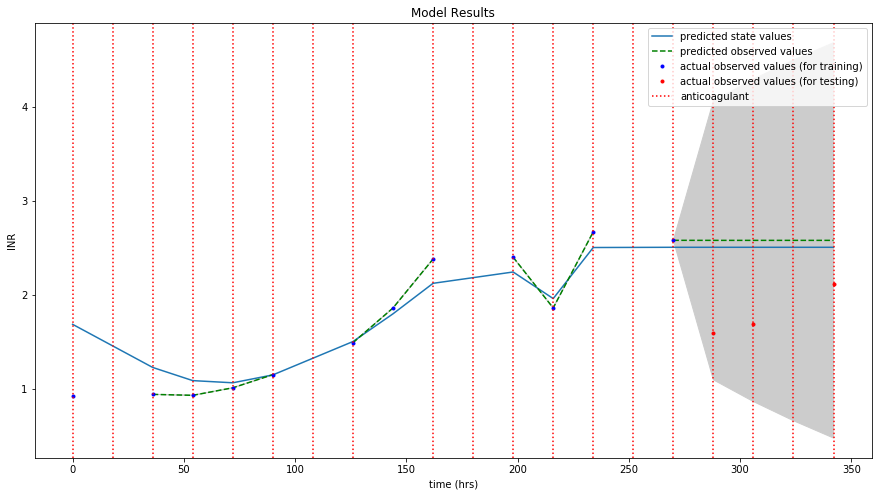

Patient 143


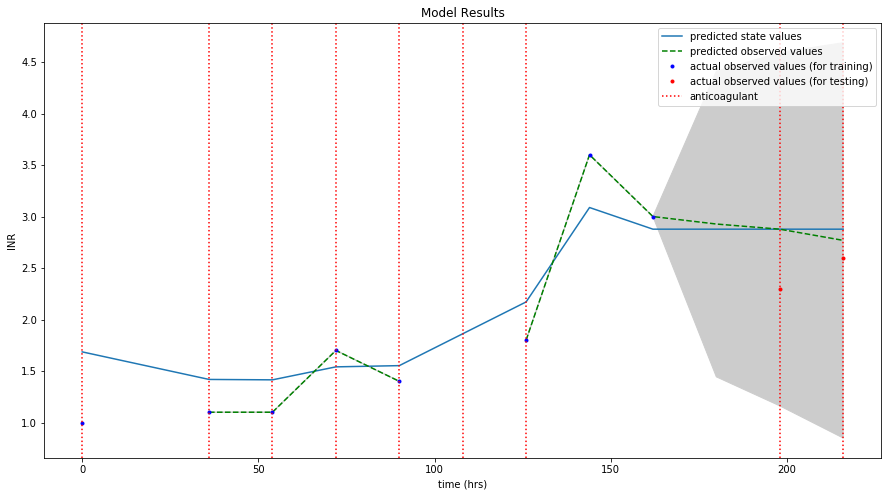

Patient 786


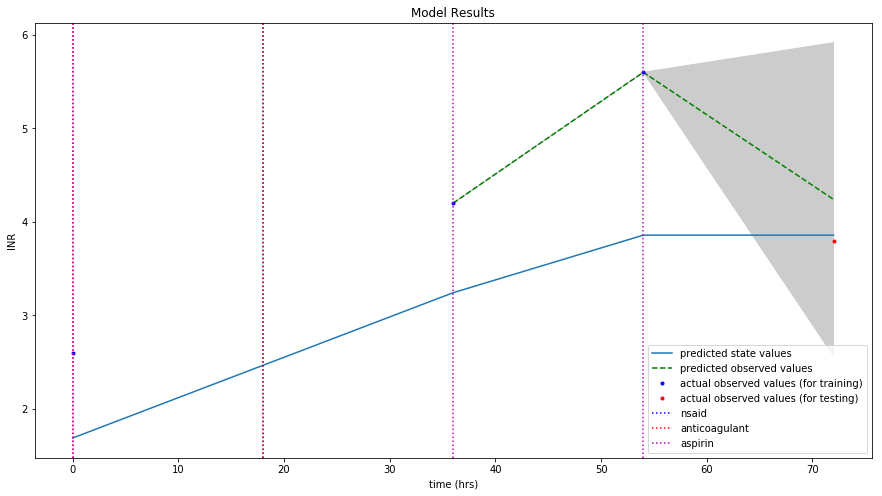

Patient 1931


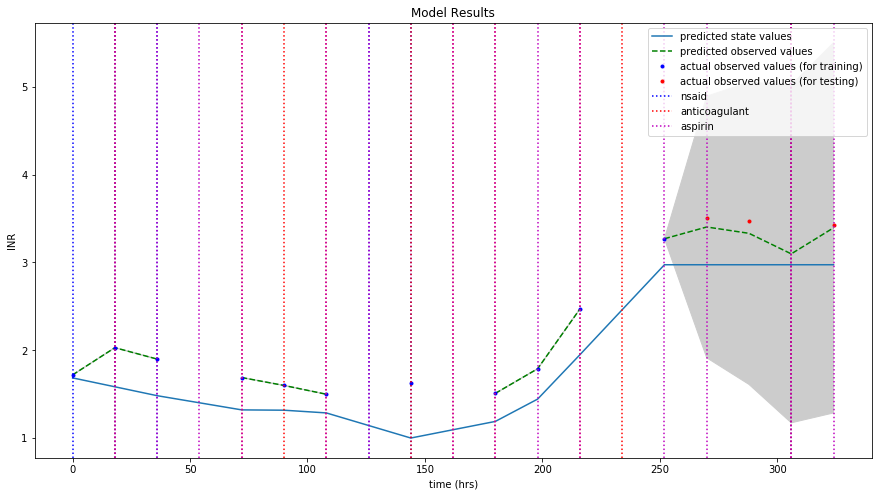

Patient 376


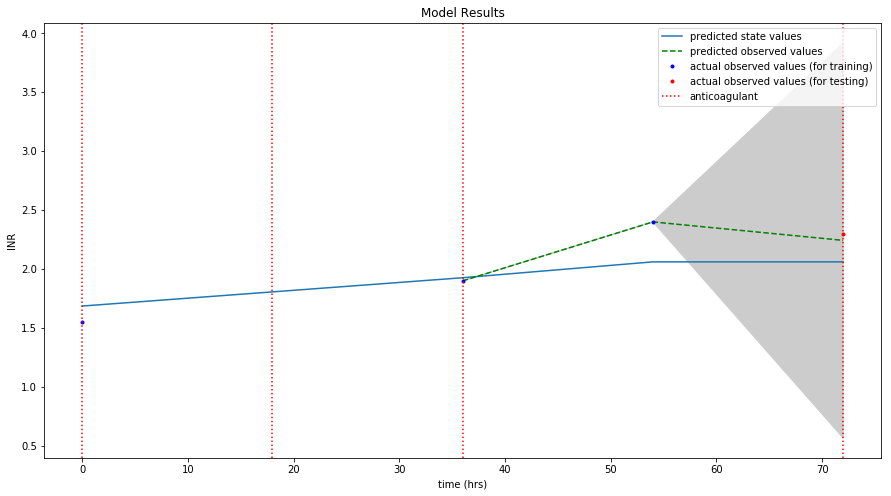

Patient 331


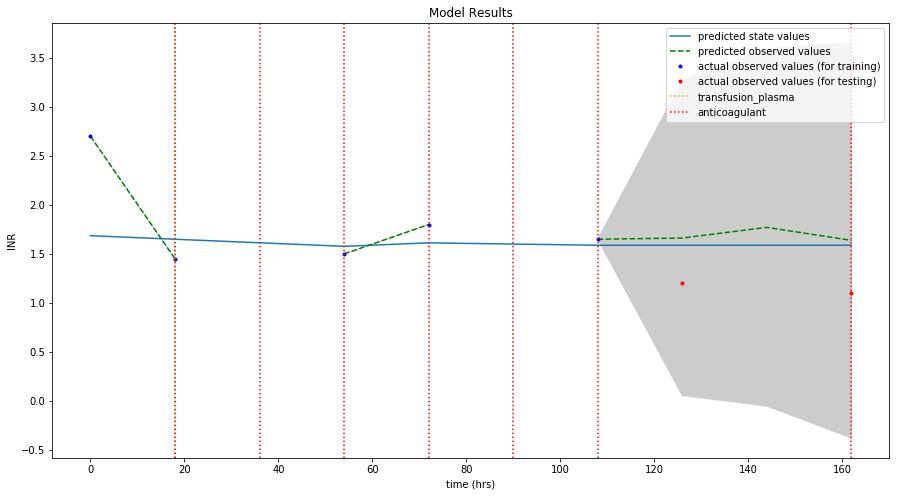

Patient 1981


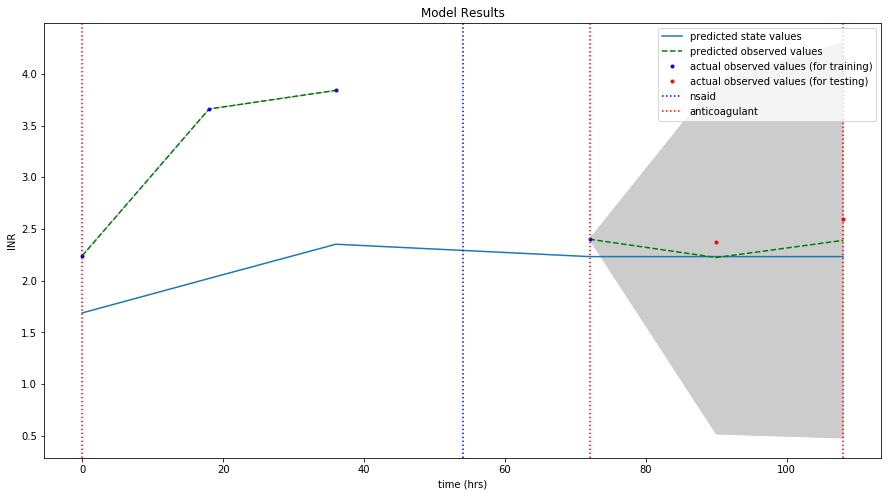

Patient 1879


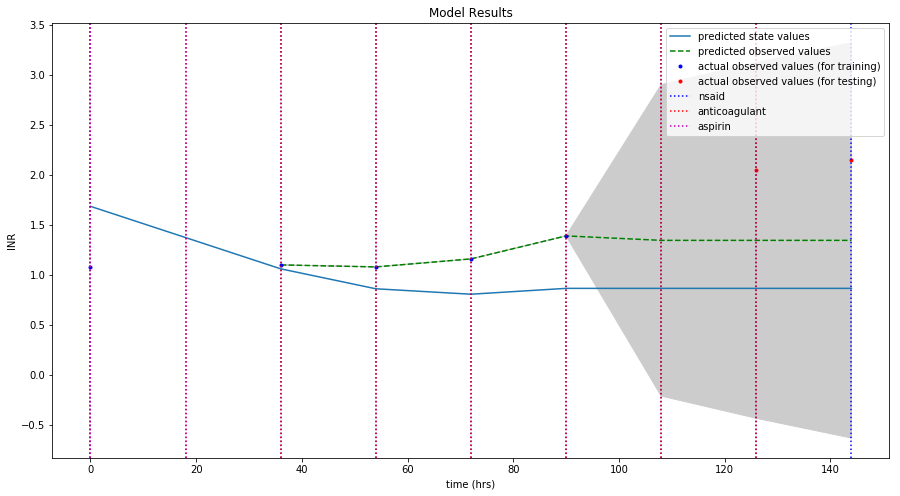

Patient 1086


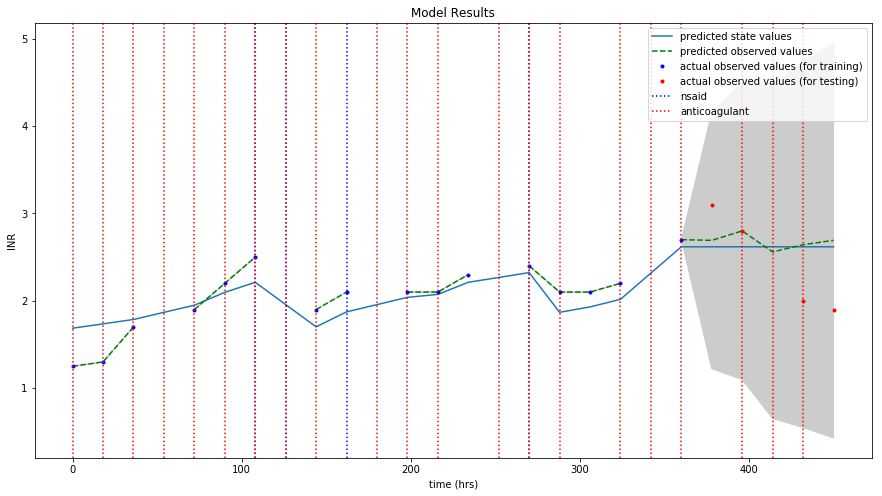

Patient 1769


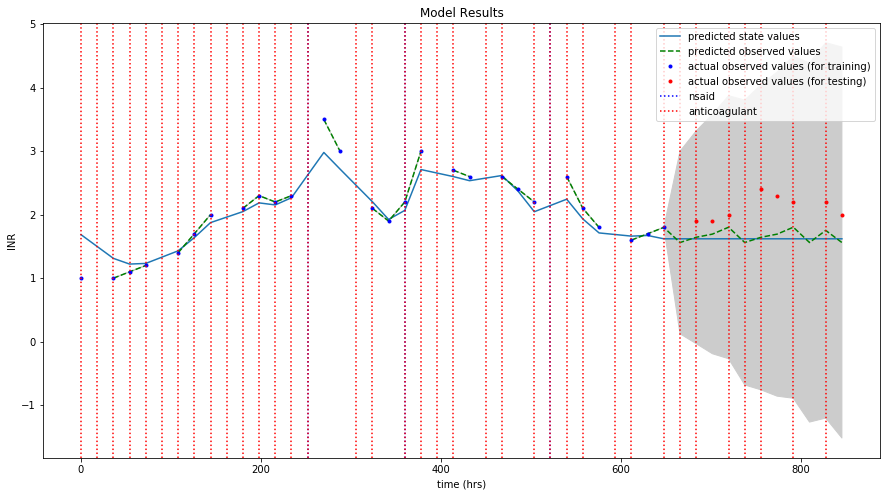

Patient 356


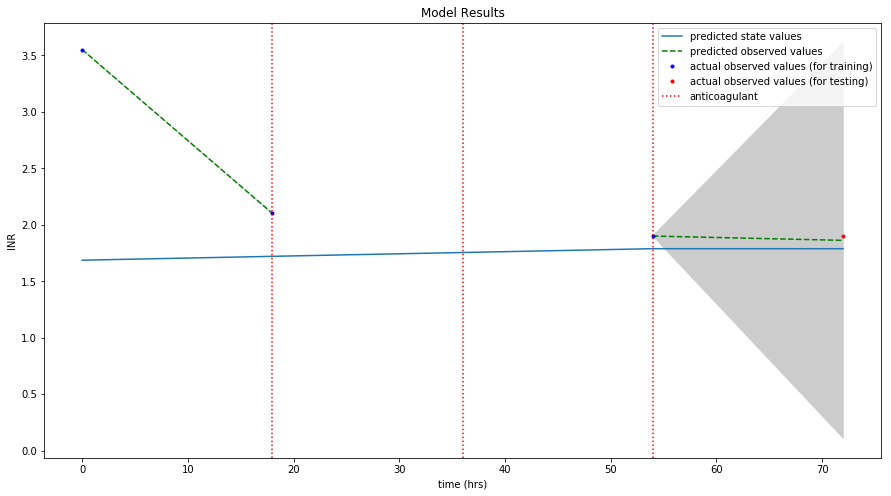

Patient 454


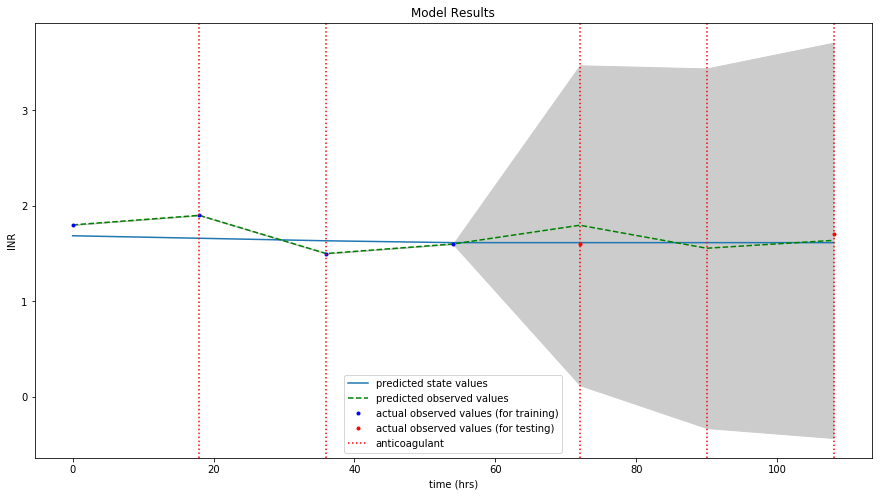

Patient 1141


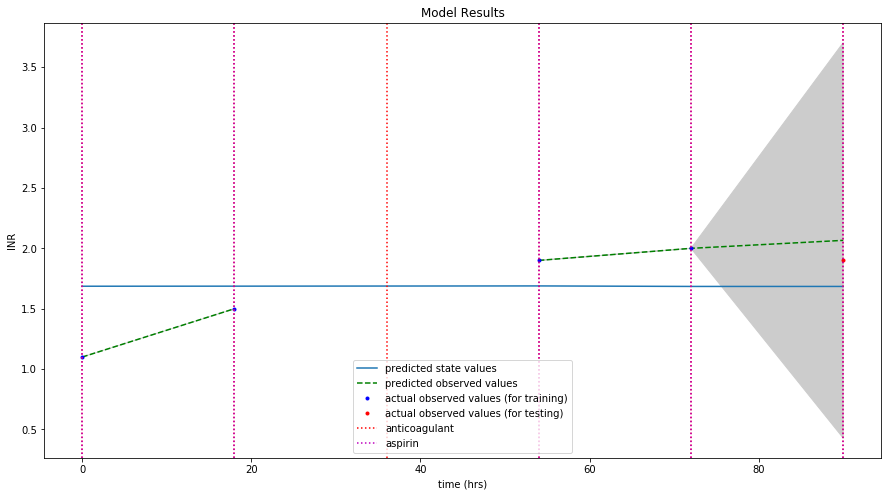

Patient 1272


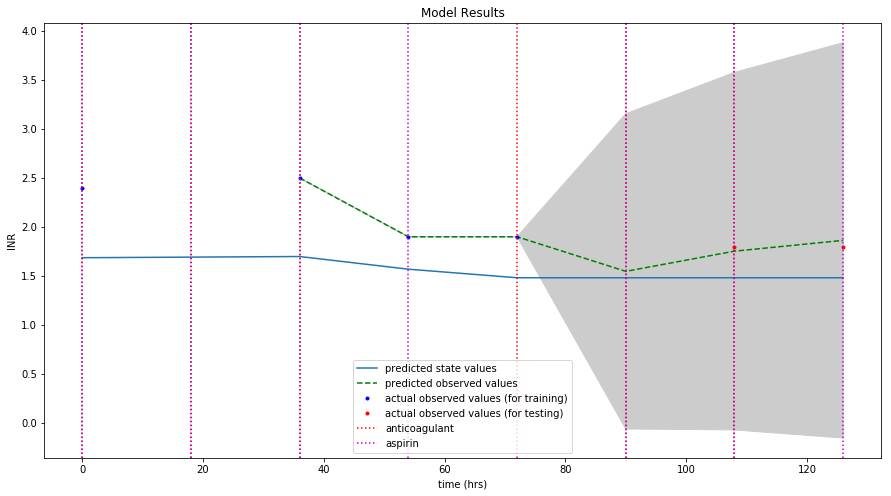

Patient 1227


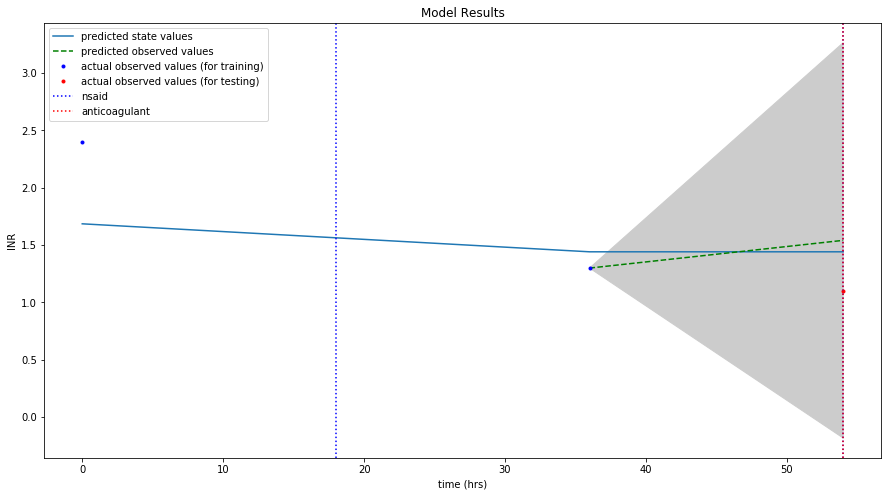

Patient 1829


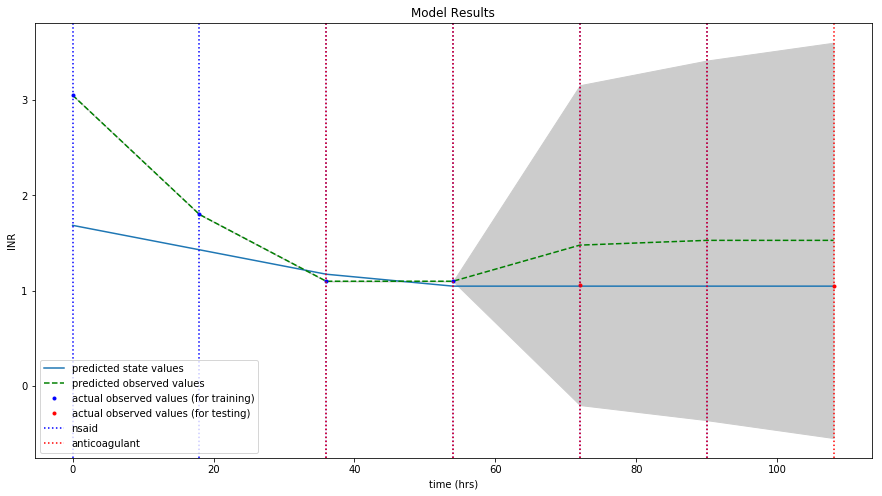

Patient 1101


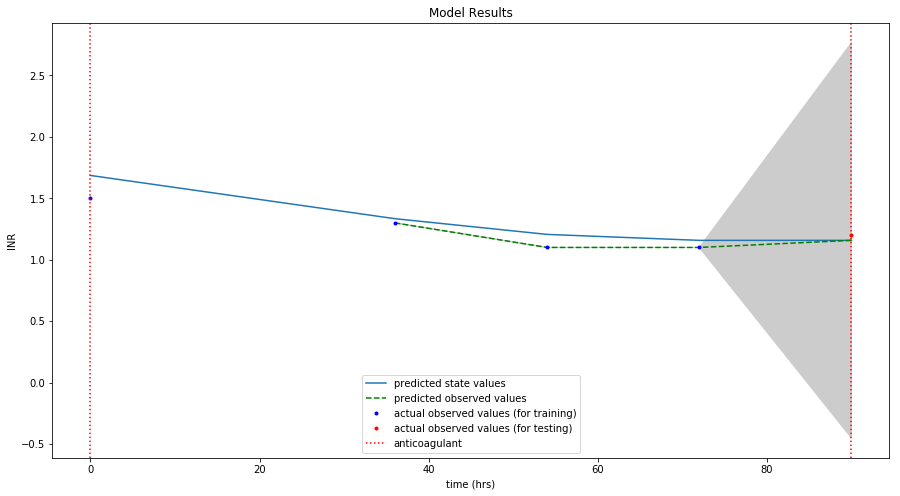

Patient 1889


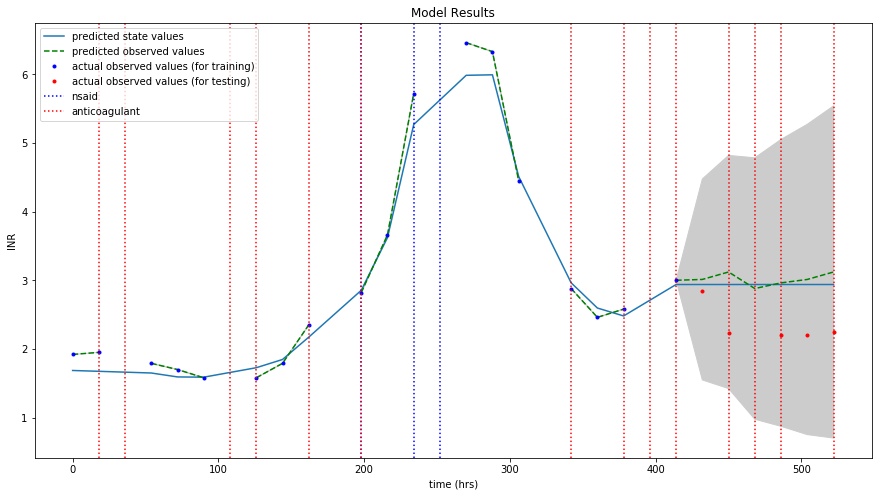

Patient 420


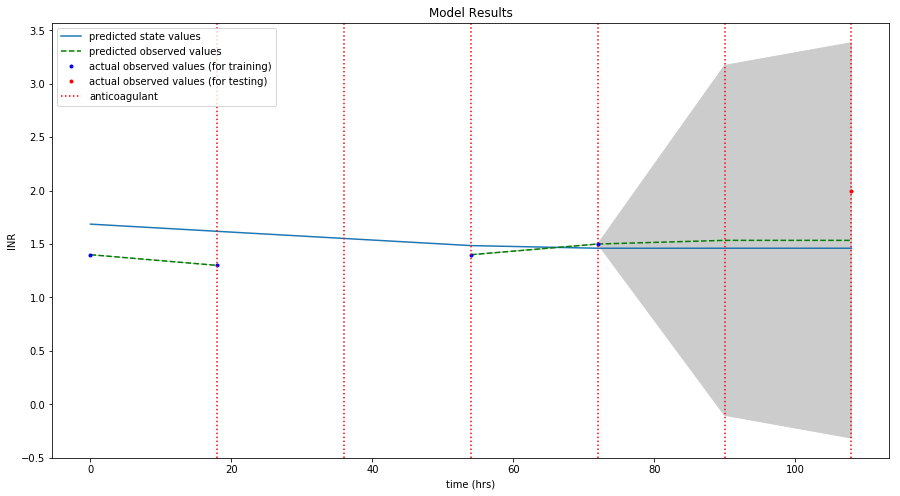

Patient 642


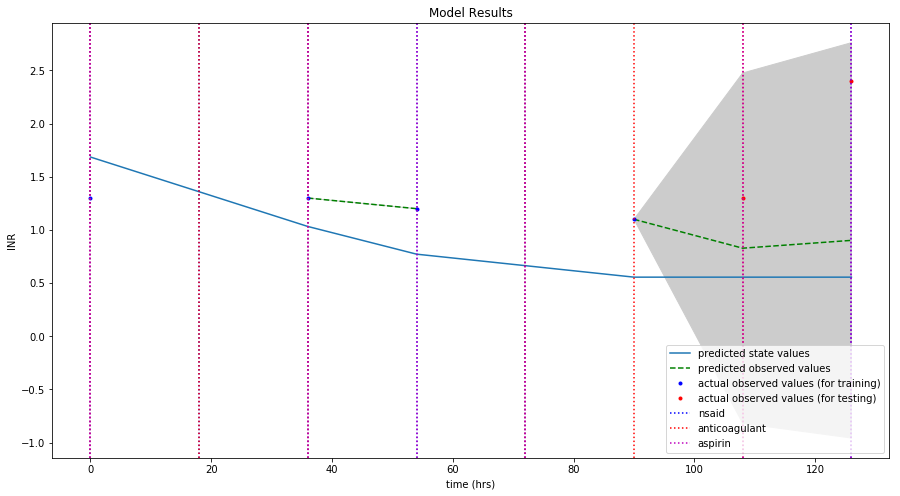

Patient 968


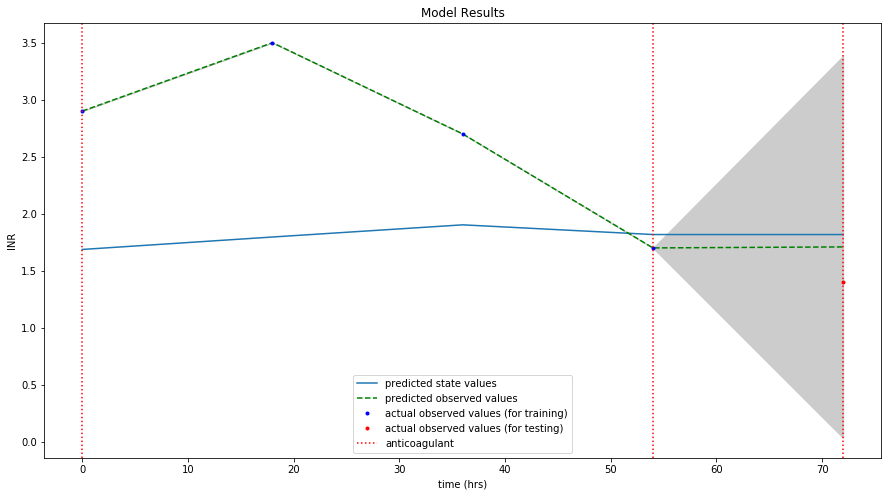

Patient 440


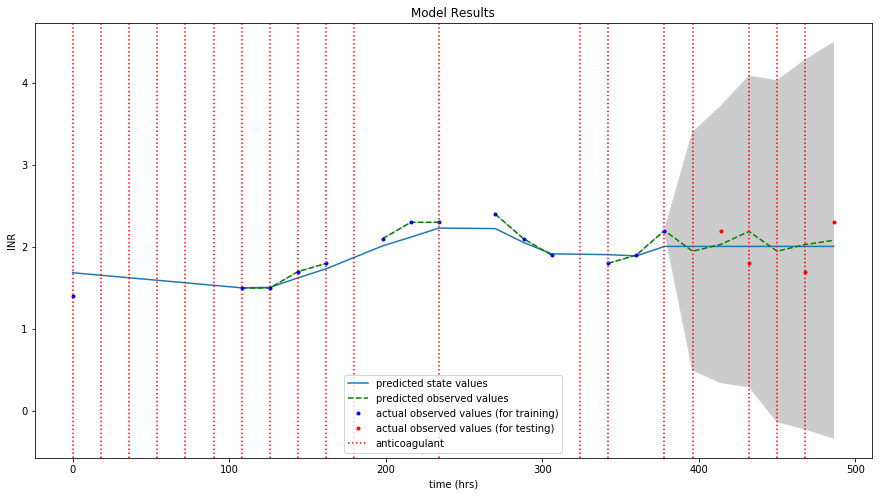

Patient 362


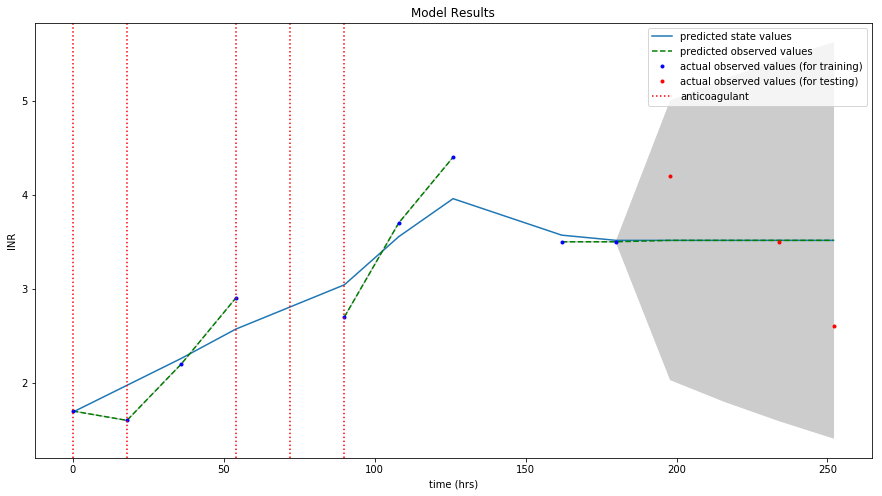

Patient 2168


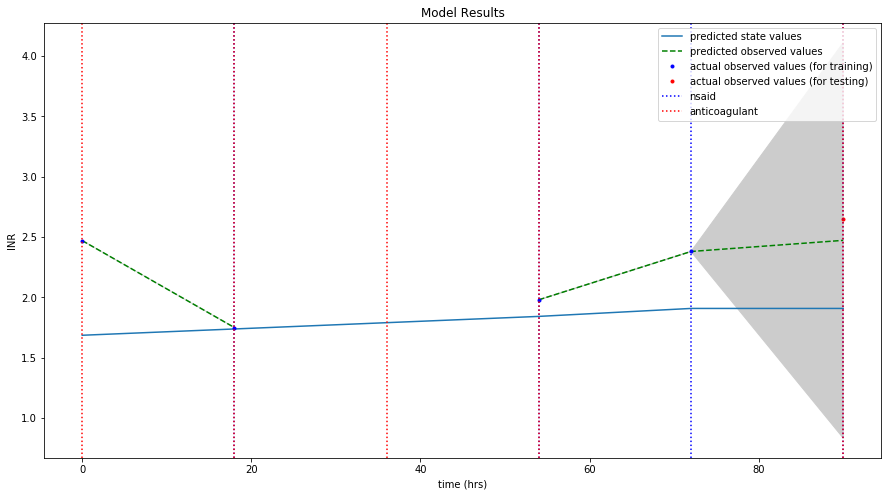

Patient 55


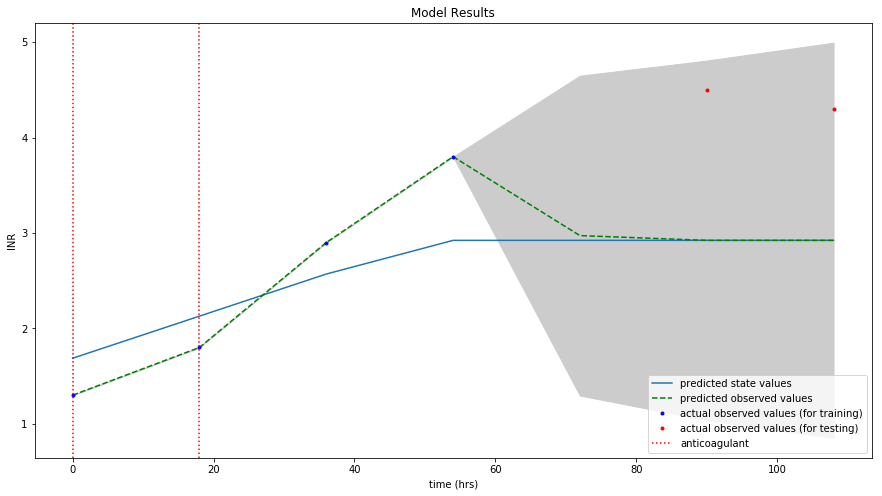

Patient 1943


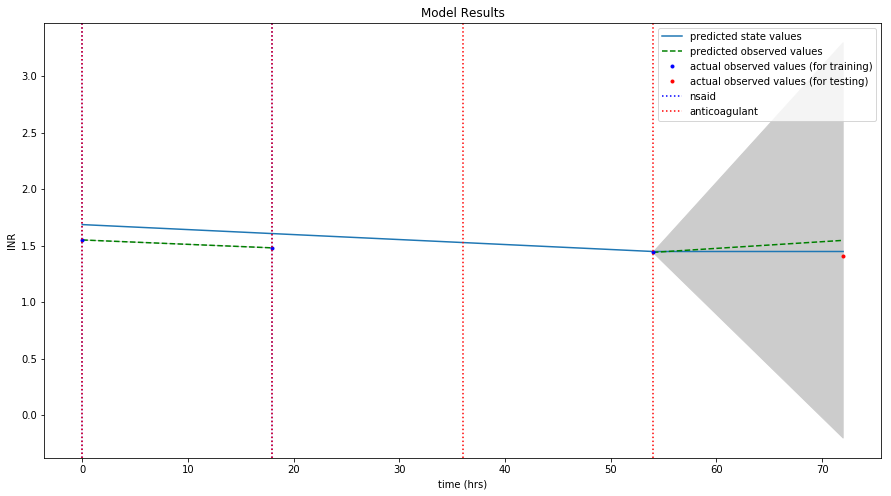

Patient 1771


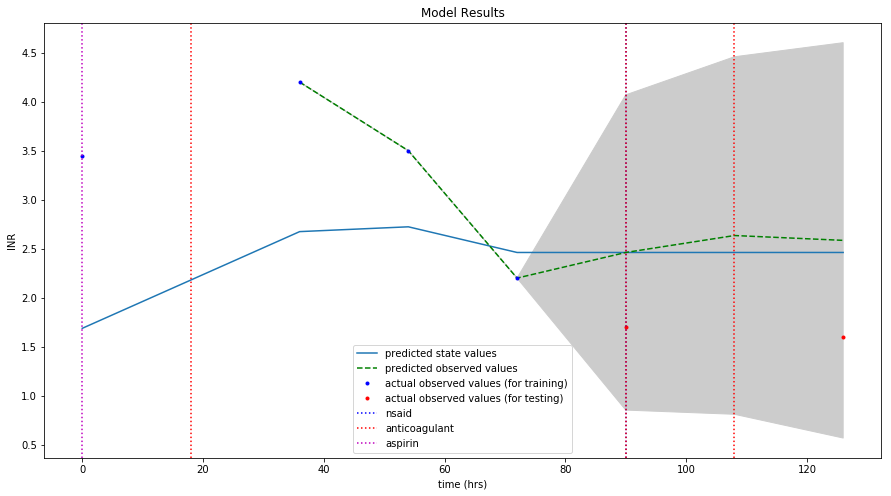

Patient 1880


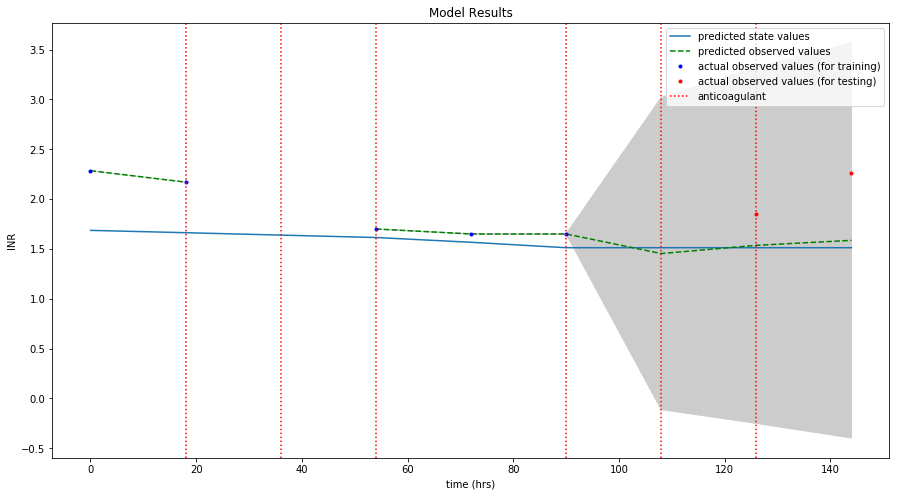

Patient 2197


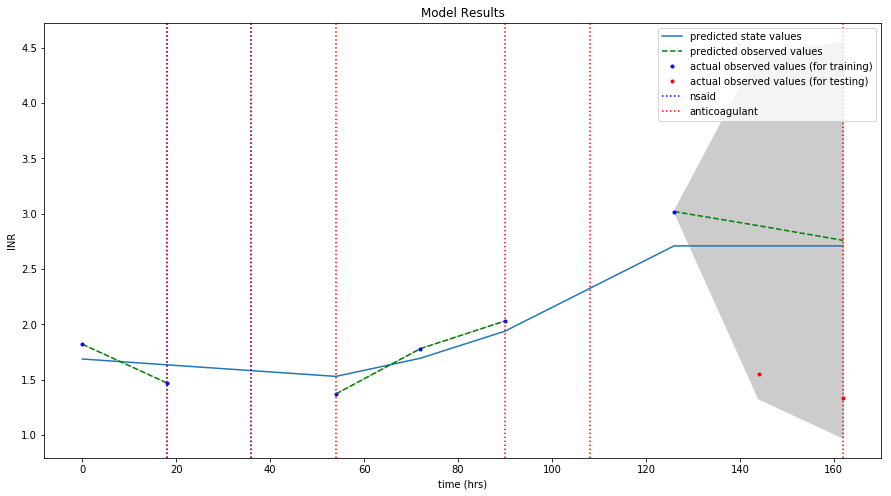

Patient 1256


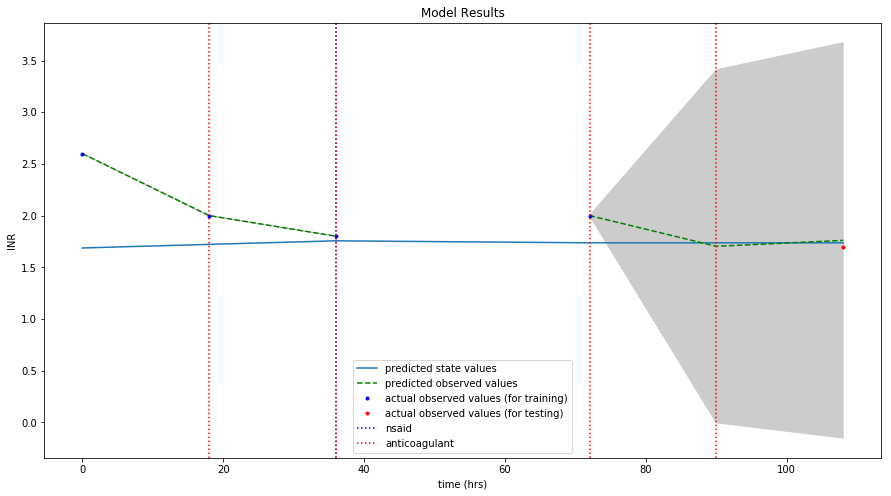

Patient 984


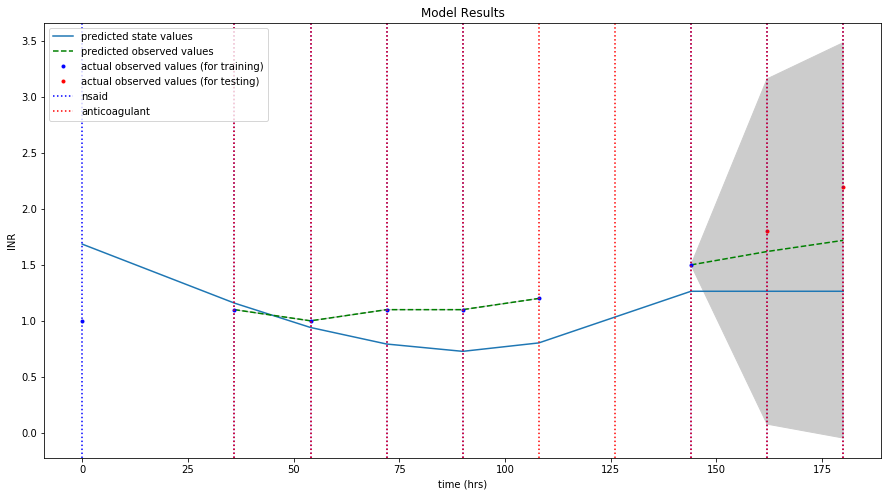

Patient 1196


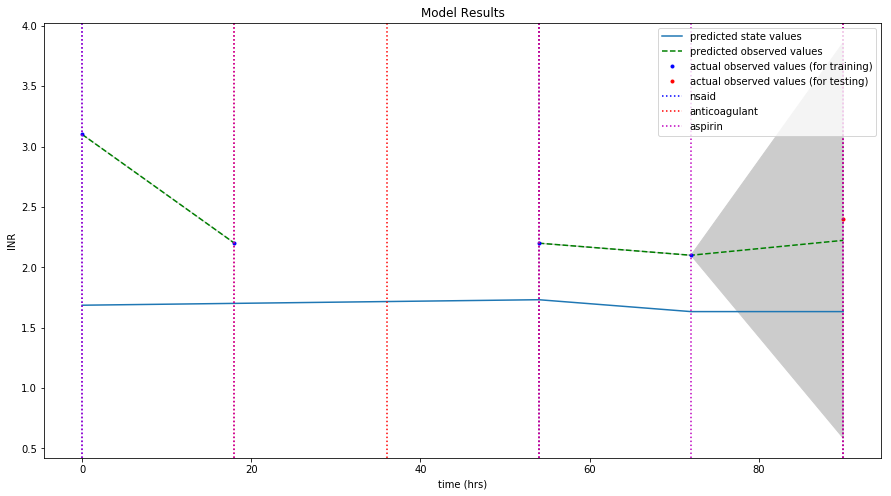

In [17]:
random_patients = np.random.randint(0, y.shape[0], 50)
for i in random_patients:
    plot(em, i, bin_size=bin_size)